In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np

import dynchro

In [3]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [4]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

In [5]:
d1.write("data/fastmnn1.h5ad")
d2.write("data/fastmnn2.h5ad")

Now go run `3c_fastmnn.R`

In [6]:
fastmnn = ad.read_h5ad("data/fastmnn_result.h5ad")

## Fastmnn

In [7]:
fastmnn

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'batch'
    obsm: 'corrected'

In [8]:
fastmnn.obsm["X_fastmnn"] = fastmnn.obsm["corrected"]
fastmnn.obs["milestones"] = np.concatenate((d1.obs["milestones"], d2.obs["milestones"]))
fastmnn.obs["sim_time"] = np.concatenate((d1.obs["sim_time"], d2.obs["sim_time"]))
fastmnn.obs["batch"] = [0] * d1.shape[0] + [1] * d2.shape[0]
fastmnn.obs["linC"] = np.concatenate((d1.obs["linC"], d2.obs["linC"]))
fastmnn.obs["linD"] = np.concatenate((d1.obs["linD"], d2.obs["linD"]))
fastmnn.obs["orig_linC_pseudotime"] = np.concatenate((d1.obs["orig_linC_pseudotime"], d2.obs["orig_linC_pseudotime"]))
fastmnn.obs["orig_linD_pseudotime"] = np.concatenate((d1.obs["orig_linD_pseudotime"], d2.obs["orig_linD_pseudotime"]))

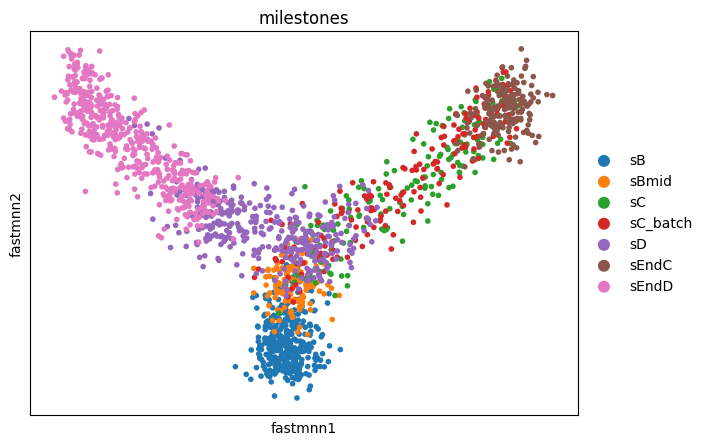

In [9]:
sc.pl.scatter(fastmnn, basis = "fastmnn", color = "milestones")

In [10]:
fastmnn.obs

,batch,milestones,sim_time,linC,linD,orig_linC_pseudotime,orig_linD_pseudotime
cell1,0,sD,150.083333,TRUE,TRUE,23.849089,23.534008
cell2,0,sD,460.083333,FALSE,TRUE,NaN,42.164078
cell3,0,sEndD,380.083333,FALSE,TRUE,NaN,41.690671
cell4,0,sD,190.000000,TRUE,TRUE,21.807524,20.238094
cell5,0,sEndC,530.083333,TRUE,FALSE,57.245446,NaN
...,...,...,...,...,...,...,...
cell996_2,1,sC_batch,160.000000,TRUE,TRUE,29.337826,22.465927
cell997_2,1,sEndD,380.083333,FALSE,TRUE,NaN,35.284809
cell998_2,1,sD,240.000000,TRUE,TRUE,23.197623,21.402175
cell999_2,1,sD,130.083333,TRUE,TRUE,21.857863,20.149078


In [11]:
sc.pp.neighbors(fastmnn, use_rep="X_fastmnn")


/tmp/ipykernel_2405969/1170098195.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(fastmnn, resolution=1, key_added="leiden1")


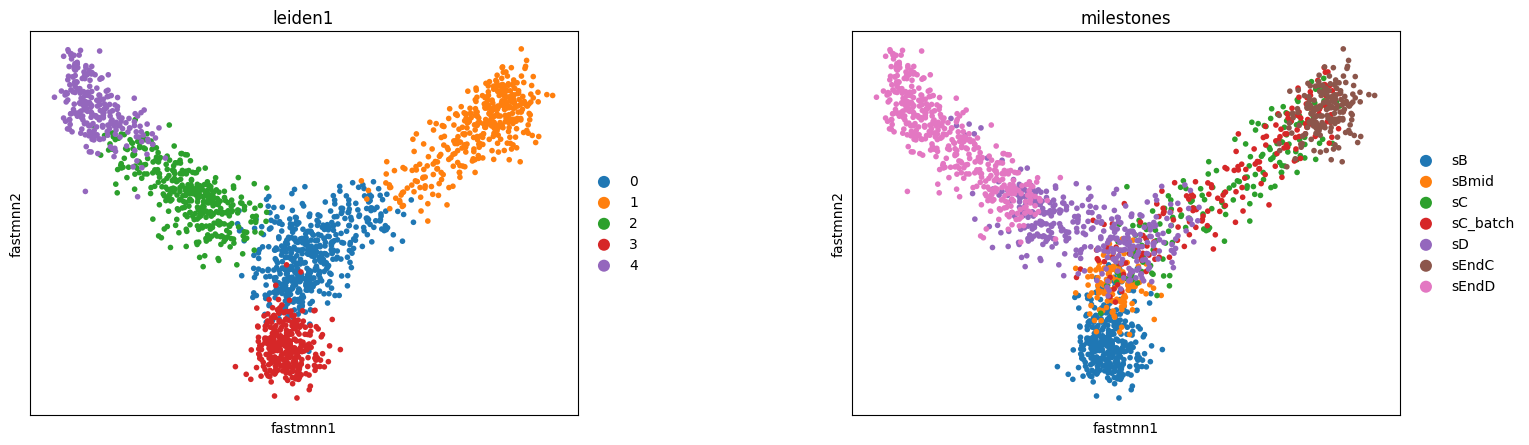

In [12]:
sc.tl.leiden(fastmnn, resolution=1, key_added="leiden1")
sc.pl.scatter(fastmnn, basis="fastmnn", color=["leiden1", "milestones"])


In [13]:
fastmnn.write("data/fastmnn.h5ad")

Run slingshot in R:

Run part "fastmnn" in `slingshot.R` before continuing

## Pseudotime

In [14]:
fastmnn_result = ad.read_h5ad("data/fastmnn_slingshot.h5ad")

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


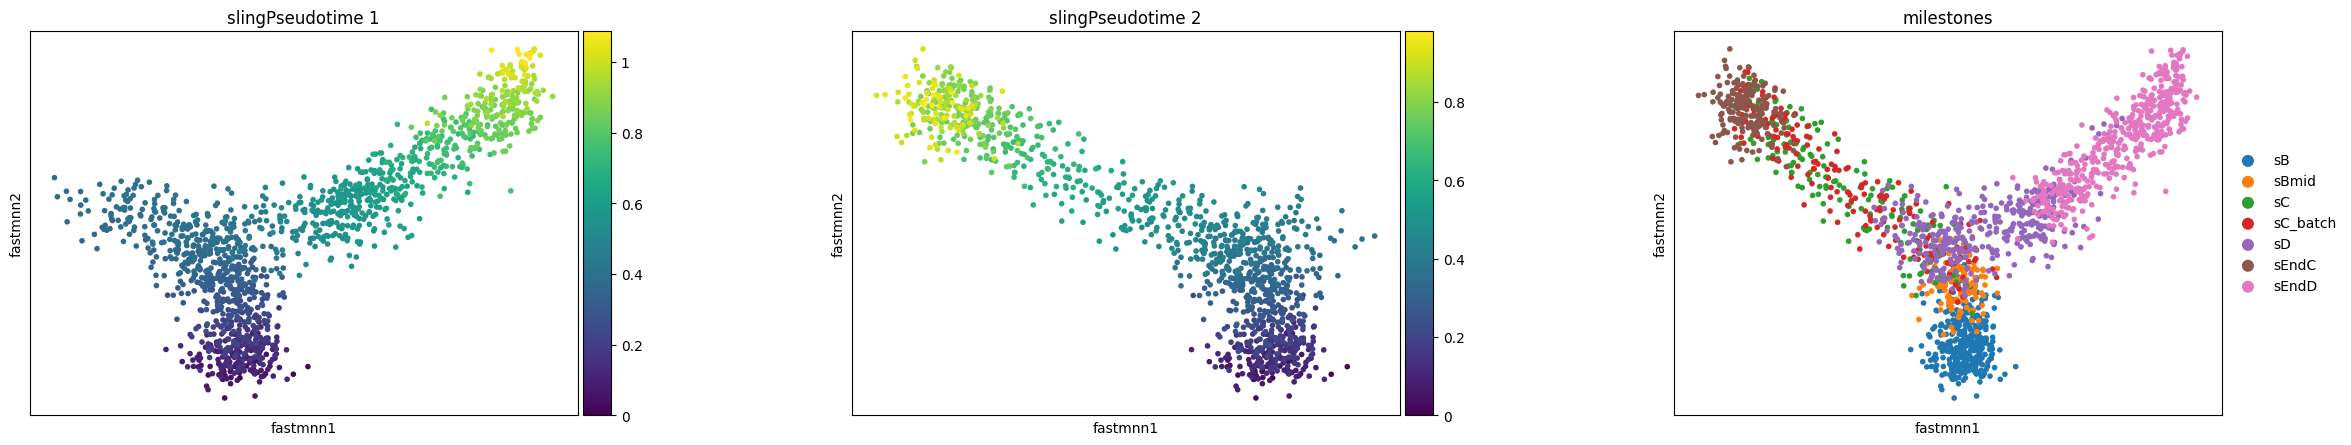

In [15]:
sc.pl.scatter(fastmnn_result, basis = "fastmnn", color = ["slingPseudotime_1", "slingPseudotime_2", "milestones"])

In [16]:
clin = fastmnn_result[~fastmnn_result.obs["slingPseudotime_2"].isna()]
dlin = fastmnn_result[~fastmnn_result.obs["slingPseudotime_1"].isna()]

In [17]:
# make category of batches
clin.obs["batch"] = clin.obs["batch"].astype("category")
dlin.obs["batch"] = dlin.obs["batch"].astype("category")

/tmp/ipykernel_2405969/1776503470.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  clin.obs["batch"] = clin.obs["batch"].astype("category")
/tmp/ipykernel_2405969/1776503470.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dlin.obs["batch"] = dlin.obs["batch"].astype("category")


# Calculate kde densities

In [ ]:
clin_after = clin
dlin_after = dlin

# these are the cells belonging to lineages c and d in the non-corrected data
clin_orig = fastmnn_result[fastmnn_result.obs.linC == "TRUE"]
dlin_orig = fastmnn_result[fastmnn_result.obs.linD == "TRUE"]

In [20]:
# Here we calculate where the first cell in the "sEndC" milestone is located in the original pseudotime, 
# and in the normalized scale (0-1)

startC = min(clin_orig[clin_orig.obs["milestones"] == "sC"].obs["orig_linC_pseudotime"])
startEndC = min(clin_orig[clin_orig.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
linmin = min(clin_orig.obs["orig_linC_pseudotime"])
linmax = max(clin_orig.obs["orig_linC_pseudotime"])

startC_normalized = (startC - linmin) / (linmax - linmin)
startEndC_normalized = (startEndC - linmin) / (linmax - linmin)

startC_normalized, startEndC_normalized

(0.18798988170404404, 0.5908188837727303)

In [ ]:
bw = 0.1
pseudotimes =["orig_linC_pseudotime", "slingPseudotime_2"]
method = "fastmnn"

d1_b_linC = clin_orig[clin_orig.obs["batch"] == "control"]
d2_b_linC = clin_orig[clin_orig.obs["batch"] == "premature stop"]

d1_a_linC = clin_after[clin_after.obs["batch"] == "control"]
d2_a_linC = clin_after[clin_after.obs["batch"] == "premature stop"]

res1_orig = dynchro.tl.get_kde_eval(d1_b_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res1_after = dynchro.tl.get_kde_eval(d1_a_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

res2_orig = dynchro.tl.get_kde_eval(d2_b_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res2_after = dynchro.tl.get_kde_eval(d2_a_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

both_orig = dynchro.tl.get_kde_eval(clin_orig, pseudotimes[0], mode = "only_results", bandwidth = bw)
both_after = dynchro.tl.get_kde_eval(clin_after, pseudotimes[1], mode = "only_results", bandwidth = bw)

dump = {
    "d1": {
        "orig": res1_orig,
        "after": res1_after,
        "cutoff": startEndC_normalized,
    },
    "d2": {
        "orig": res2_orig,
        "after": res2_after,
        "cutoff": startEndC_normalized,
    },
    "both": {
        "orig": both_orig,
        "after": both_after,
        "cutoff": startEndC_normalized,
    }
}
import pickle
pickle.dump(dump, open(f"data/{method}_dump.p", "wb"))

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_linC_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_linC_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataset.obs[f"norm_{pseudotime_key}"] = vector
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_linC_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_linC_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view 